In [1]:
#!/usr/bin/env python3
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import astropy.units as u
from sunpy.time import TimeRange
import time
import sys

import datetime as dt
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm

from sk import LofarRaw 

%matplotlib inline

In [2]:
filename = 'udpoutput/jupiter-stokesI_0_2020-10-13T17:45:00_19563123779296'
frange = [15,60]
sbs = np.arange(76,320)
obs_mode = 3
trange = TimeRange("2020-10-13T17:45:00", 15.*u.min)
xlabel = "Time from 2020/10/13 17:47:00.0000"
ylabel = "Frequency (MHz)"
title = filename.split('/')[1]

In [3]:
raw = LofarRaw(fname=filename, sbs=sbs, obs_mode=obs_mode, frange=frange)
flimits = np.array([40,94])
freqlimits = raw.sb_to_f(flimits+sbs[0], obs_mode)
xlims = list(map(dt.datetime.fromisoformat, [trange.start.value, trange.end.value]))
xlims = mdates.date2num(xlims)
raw.data = raw.data[:, flimits[0]:flimits[1]]

Time to read data: 0.000817s



In [5]:
#raw.data = raw.data[::100]
norm_seconds = 30 #the resolution of poly fitting
norm_splits = int((15*60)/norm_seconds)
print(norm_splits)
poly_splits = 1000

30


In [6]:
arrays = np.array_split(raw.data, norm_splits)
#arrays = [(arr/np.quantile(arr, 0.1, axis=0)) for arr in arrays]
for arr in arrays:
    arr = arr/np.quantile(arr, 0.1, axis=0)
data = np.vstack(arrays)

In [7]:
rfi_bands = [0, 1, 6, 7, 25, 51, 52, 53] #dominant rfi bands 0->20 + 31, 32, 38
rfi_freqs = raw.sb_to_f(np.array(rfi_bands) + flimits[0] + sbs[0], obs_mode)
print("\nMasked subbands: {}\nMasked frequencies: {}\n".format(np.array(rfi_bands)+flimits[0], rfi_freqs))


Masked subbands: [40 41 46 47 65 91 92 93]
Masked frequencies: [22.65625   22.8515625 23.828125  24.0234375 27.5390625 32.6171875
 32.8125    33.0078125] MHz



In [8]:
data[:, rfi_bands] = np.nan ###removing rfi bands from data(set to nan, will be masked later)

In [9]:
arrs = np.array_split(data, poly_splits)
for arr in arrs:
    for i in np.arange(arr.shape[1]):
        if np.any(np.isnan(arr[:,i])):
            pass
        else:
            coeffs = np.polyfit(np.linspace(0, len(arr[:,i]), len(arr[:, i])), arr[:, i], 2)
            ynew = np.poly1d(coeffs)
            arr[:, i] = ynew(np.linspace(0, len(arr[:, i]), len(arr[:, i])))
data = np.vstack(arrs)

In [10]:
data = np.ma.masked_invalid(data)

In [14]:
arrays = np.array_split(data, norm_splits)
for arr in arrays:
    arr = arr/np.quantile(arr, 0.1, axis=0)
data = np.vstack(arrays)

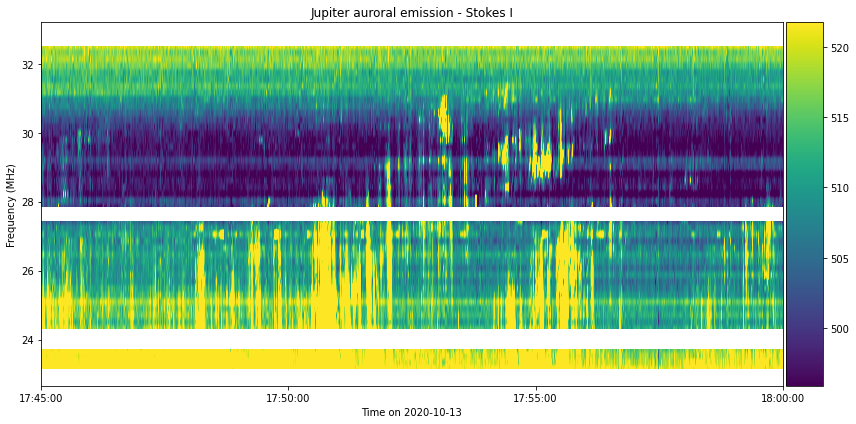

In [12]:
plt.figure(figsize=(12,6))
im = plt.imshow(data.T, aspect='auto', origin='lower',
            vmin=np.nanpercentile(data.T.compressed(), 5), 
            vmax=np.nanpercentile(data.T.compressed(), 90),
            extent=[xlims[0], xlims[1], 
                    freqlimits[0].value, freqlimits[1].value])

plt.gca().xaxis_date()
date_format = mdates.DateFormatter('%H:%M:%S')
plt.gca().xaxis.set_major_formatter(date_format)

plt.title("Jupiter auroral emission - Stokes I")
plt.ylabel(ylabel)
plt.xlabel('Time on 2020-10-13')

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

plt.tight_layout()

In [16]:
norms = np.quantile(data, 0.1, axis=0)
data = data/norms

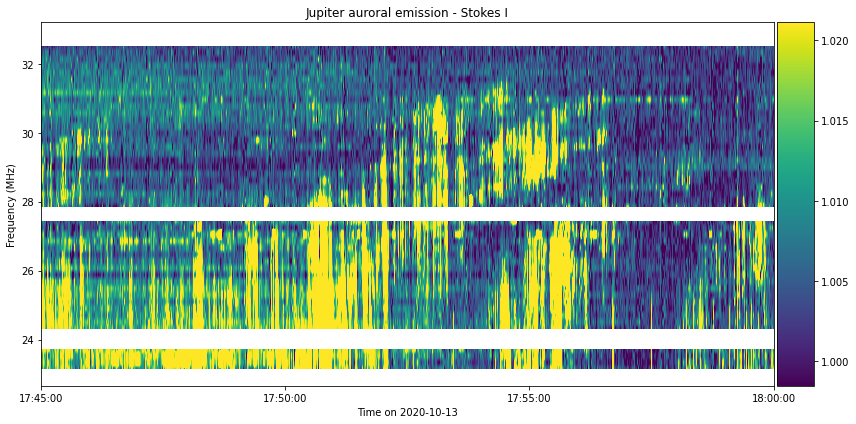

In [17]:
plt.figure(figsize=(12,6))
im = plt.imshow(data.T, aspect='auto', origin='lower',
            vmin=np.nanpercentile(data.T.compressed(), 5), 
            vmax=np.nanpercentile(data.T.compressed(), 90),
            extent=[xlims[0], xlims[1], 
                    freqlimits[0].value, freqlimits[1].value])

plt.gca().xaxis_date()
date_format = mdates.DateFormatter('%H:%M:%S')
plt.gca().xaxis.set_major_formatter(date_format)

plt.title("Jupiter auroral emission - Stokes I")
plt.ylabel(ylabel)
plt.xlabel('Time on 2020-10-13')

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

plt.tight_layout()

In [ ]:
data.shape

In [51]:
##try resample
summed = np.cumsum(data, axis=0)

In [52]:
summed.shape

(10986328, 54)

In [53]:
dec = 32
decimated = summed[dec::dec, :] - summed[:-dec:dec, :]

arrs = np.array_split(decimated, 1000)
for arr in arrs:
    for i in np.arange(arr.shape[1]):
        if np.any(np.isnan(arr[:,i])):
            pass
        else:
            coeffs = np.polyfit(np.linspace(0, len(arr[:,i]), len(arr[:, i])), arr[:, i], 2)
            ynew = np.poly1d(coeffs)
            arr[:, i] = ynew(np.linspace(0, len(arr[:, i]), len(arr[:, i])))
data = np.vstack(arrs)

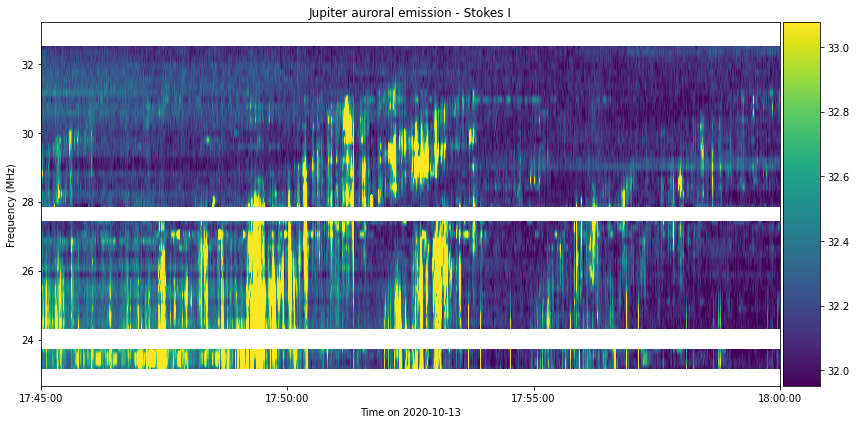

In [54]:
plt.figure(figsize=(12,6))
im = plt.imshow(decimated.T, aspect='auto', origin='lower',
            vmin=np.nanpercentile(decimated.compressed(), 5), 
            vmax=np.nanpercentile(decimated.compressed(), 95),
            extent=[xlims[0], xlims[1], 
                    freqlimits[0].value, freqlimits[1].value])

plt.gca().xaxis_date()
date_format = mdates.DateFormatter('%H:%M:%S')
plt.gca().xaxis.set_major_formatter(date_format)

plt.title("Jupiter auroral emission - Stokes I")
plt.ylabel(ylabel)
plt.xlabel('Time on 2020-10-13')

divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

plt.tight_layout()